In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import acf
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

import os
import math

In [2]:
data_dir = '../data/planetlab'
# smooth_csv = ('20110303', 'ait05_us_es_root')
smooth_csv = ('20110306', 'planetlab1_cs_purdue_edu_purdue_2')
trend_csv = ('20110412', 'planet1_scs_cs_nyu_edu_uw_oneswarm')
period_csv = ('20110403', 'planetlab2-santiago_lan_redclara_net_ethzcs_tracegatherer')

smooth_df = pd.read_csv(os.path.join(data_dir, *smooth_csv))
trend_df = pd.read_csv(os.path.join(data_dir, *trend_csv))
period_df = pd.read_csv(os.path.join(data_dir, *period_csv))

In [3]:
def saf(ts):
    """spectrum analyse function
    返回分析时序数据频谱特征
    """
    # 快速傅立叶变化，值域->频域
    ts_dft = np.fft.fft(ts)
    m = len(ts_dft) / 2
    # 获得频谱特征
    Q = ts_dft**2 / m
    return Q

def is_period(ts):
    """判断是否周期型
    """
    Q = saf(ts)
    # 对频谱特征进行差分，使特征更加明显
    H = np.array([])
    for i in range(1, math.ceil(len(Q)/2)):
        h = abs((Q[i] - Q[i+1]) + (Q[i] - Q[i-1]))
        H = np.append(H, h)
    # 3-𝜎规则判定是否属于周期型
    mean = np.mean(H)
    std = np.std(H)
    is_period, period = False, 0
    ## 排除H[0]（表示周期数为1，即将整个数据作为一个周期）
    for i in range(1, len(H)):
        if H[i] - mean > 3*std:
            is_period, period = True, int(len(H)/(i+1))
    return is_period, period

In [4]:
def is_smooth(ts, u=0, alpha=0.05):
    """判断是否平稳型
    """
    P = acf(ts)
    t, p = stats.ttest_1samp(P, u)
    is_smooth = (p > alpha)
    return is_smooth

def is_smooth_score(ts, u=0, alpha=0.05):
    """判断是否平稳型，并输出与平稳序列接近程度（score越小，越接近平稳）
    """
    P = acf(ts)
    t, p = stats.ttest_1samp(P, u)
    is_smooth = (p > 0.05)
    score = (P.mean() - u) / (P.std())
    return is_smooth, score

In [5]:
def pre(*args):
    """数据预处理
    返回负载序列，共287个点，24小时，每5分钟一个点
    """
    loads = []
    for df in args:
        df.columns = ['load']
        df = df.dropna()
        loads.append(df['load'])
    return tuple(loads)

def workload_aware(ts):
    """负载趋势感知
    """    
    flag, period = is_period(ts)
    if flag:
        return 'PERIOD', period
    if is_smooth(ts):
        return 'SMOOTH', 0
    return 'TREND', 0

In [6]:
smooth_ts, trend_ts, period_ts = pre(smooth_df, trend_df, period_df)
workload_aware(smooth_ts), workload_aware(trend_ts), workload_aware(period_ts)

(('SMOOTH', 0), ('TREND', 0), ('PERIOD', 47))

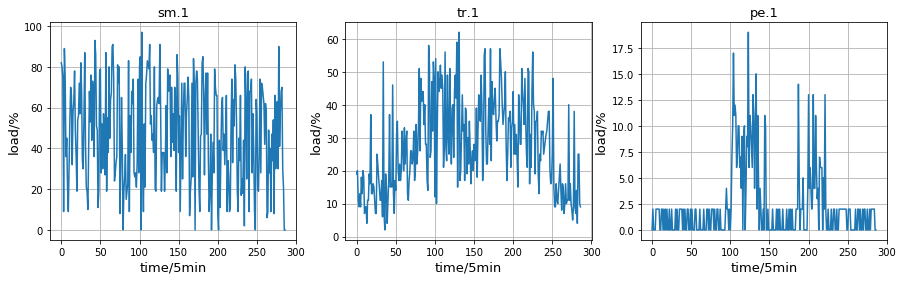

In [8]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('sm.1',fontsize=13)
plt.plot(smooth_ts)
plt.grid()
plt.ylabel('load/%',fontsize=13)
plt.xlabel('time/5min',fontsize=13)
plt.subplot(132)
plt.title('tr.1',fontsize=13)
plt.plot(trend_ts)
plt.grid()
plt.ylabel('load/%',fontsize=13)
plt.xlabel('time/5min',fontsize=13)
plt.subplot(133)
plt.title('pe.1',fontsize=13)
plt.plot(period_ts)
plt.grid()
plt.ylabel('load/%',fontsize=13)
plt.xlabel('time/5min',fontsize=13)
plt.savefig('./fig/3-8_data_of_sm_tr_pe', dpi=600)

In [8]:
def ic_for_smooth(ts):
    """为平稳型负载构造区间
    """
    ts_max, ts_min, ts_len = ts.max(), ts.min(), len(ts)
    ts_up = np.array([0.5 * (ts[i] + ts_max) for i in range(ts_len)])
    ts_low = np.array([0.5 * (ts[i] + ts_min) for i in range(ts_len)])
    return ts_up, ts_low

def ic_for_trend(ts, tstep=10):
    """为趋势型负载构造区间
    """
    ts_up, ts_low = np.array([]), np.array([])
    for i in range(0, len(ts), tstep):
        # 子区域终点
        m = min(i + tstep, len(ts))
        
        # 子区域
        sub_ts = ts[i:m]
        sub_ts_max, sub_ts_min, sub_ts_len = sub_ts.max(), sub_ts.min(), len(sub_ts)
        sub_interval = np.array([abs(sub_ts[j+1] - sub_ts[j]) for j in range(i, m-1)])
        sub_interval_mean = sub_interval.mean()
        
        # 最小二乘法判断趋势方向：上升/下降
        X = np.array([j for j in range(sub_ts_len)])
        Y = np.array([sub_ts[j] for j in range(i, m)])
        tendency = get_tendency(X, Y)
        
        if tendency == 'UP':
            sub_ts_up = np.array([(sub_ts[j] + sub_interval_mean + (sub_ts_max - sub_ts[j])/(m - j)) 
                              for j in range(i, m)])
            sub_ts_low = np.array([(sub_ts[j] - sub_interval_mean) for j in range(i, m)])
        if tendency == 'LOW':
            sub_ts_up = np.array([(sub_ts[j] + sub_interval_mean) for j in range(i, m)])
            sub_ts_low = np.array([(sub_ts[j] - sub_interval_mean - (sub_ts[j] - sub_ts_min)/(m - j)) 
                                   for j in range(i, m)])
        ts_up = np.append(ts_up, sub_ts_up)
        ts_low = np.append(ts_low, sub_ts_low)
    return ts_up, ts_low

def _trend_func(w, x):
    """趋势方向判别的回归函数
    """
    x = np.array([x, 1])
    return np.dot(w, x)

def _error(w, x, y):
    """最小二乘法误差
    """
    return _trend_func(w, x) - y

def get_tendency(X, Y, w0=[-10,10], error=_error):
    """获得区域趋势：上升/下降
    """
    w = leastsq(error, w0, args=(X, Y))
    k, b = w[0]
    if k >= 0:
        return 'UP'
    return 'LOW'

def ic_for_period(ts, period=0):
    """为周期型负载构造区间
    """
    ts_len, half_period = len(ts), int(period/2)
    ts_up, ts_low = np.array([]), np.array([])
    for i in range(ts_len):
        if i <= half_period:
            interval = np.array([abs(ts[j+1] - ts[j]) for j in range(period-1)])
            interval_mean = interval.mean()
        if i > half_period and i < ts_len - half_period:
            interval = np.array([abs(ts[j+1] - ts[j]) for j in range(i-half_period-1, i+half_period-1)])
            interval_mean = interval.mean()
        if i >= ts_len - half_period:
            interval = np.array([abs(ts[j+1] - ts[j]) for j in range(ts_len-period-1, ts_len-1)])
            interval_mean = interval.mean()
        ts_up = np.append(ts_up, ts[i] + interval_mean)
        ts_low = np.append(ts_low, ts[i] - interval_mean)
    return ts_up, ts_low

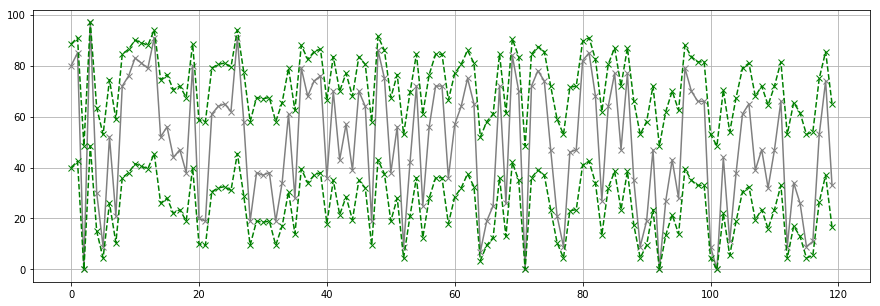

In [9]:
st, ed = 100, 220
smooth_ts_up, smooth_ts_low = ic_for_smooth(smooth_ts)
plt.figure(figsize=(15,5))
origin = smooth_ts[st:ed]
origin.index = range(len(origin))
plt.plot(origin, color='gray', marker='x')
plt.grid()
plt.plot(smooth_ts_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(smooth_ts_low[st:ed], linestyle='--', color='green', marker='x')

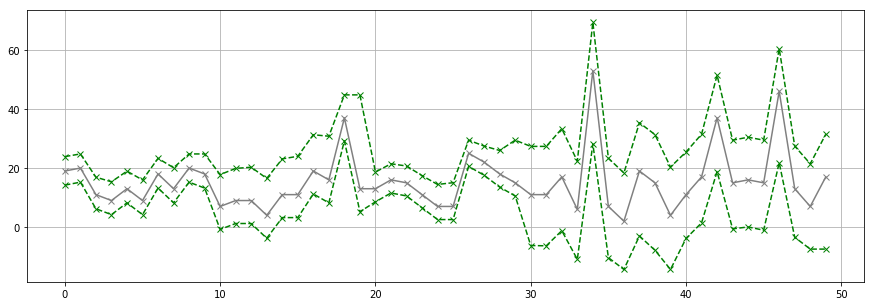

In [10]:
st, ed = 0, 50
trend_up, trend_low = ic_for_trend(trend_ts)
plt.figure(figsize=(15,5))
origin = trend_ts[st:ed]
origin.index = range(len(origin))
plt.plot(origin, color='gray', marker='x')
plt.grid()
plt.plot(trend_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(trend_low[st:ed], linestyle='--', color='green', marker='x')

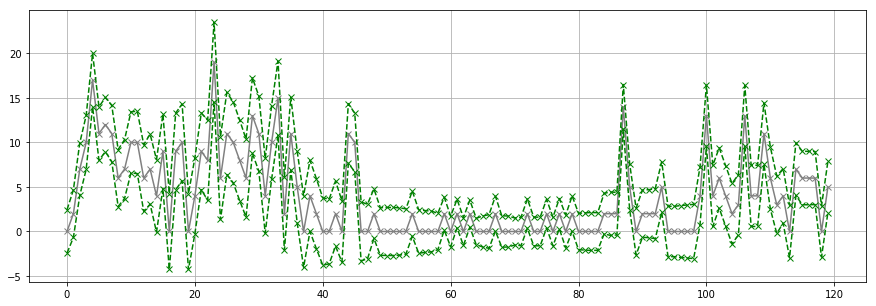

In [11]:
st, ed = 100, 220
mytype, period = workload_aware(period_ts)
period_up, period_low = ic_for_period(period_ts, period)
plt.figure(figsize=(15,5))
origin = period_ts[st:ed]
origin.index = range(len(origin))
plt.plot(origin, color='gray', marker='x')
plt.grid()
plt.plot(period_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(period_low[st:ed], linestyle='--', color='green', marker='x')

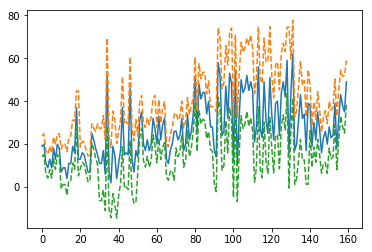

In [12]:
ts = trend_ts
tstep = 10
st = 0
ed = 160
ts_up, ts_low = np.array([]), np.array([])
for i in range(st, ed, tstep):
    m = min(i + tstep, ed)
    sub_ts = ts[i:m]
    sub_ts_max, sub_ts_min, sub_ts_len = sub_ts.max(), sub_ts.min(), len(sub_ts)
    sub_interval = np.array([abs(sub_ts[j+1] - sub_ts[j]) for j in range(i,m-1)])
    sub_interval_mean = sub_interval.mean()
#     print(sub_ts_max, sub_mean)
    X = np.array([j for j in range(m - i)])
    Y = np.array([sub_ts[j] for j in range(i, m)])
    tendency = get_tendency(X, Y)
    if tendency == 'UP':
        sub_ts_up = np.array([(sub_ts[j] + sub_interval_mean + (sub_ts_max - sub_ts[j])/(m - j)) 
                          for j in range(i, m)])
        sub_ts_low = np.array([(sub_ts[j] - sub_interval_mean) for j in range(i, m)])
    if tendency == 'LOW':
        sub_ts_up = np.array([(sub_ts[j] + sub_interval_mean) for j in range(i, m)])
        sub_ts_low = np.array([(sub_ts[j] - sub_interval_mean - (sub_ts[j] - sub_ts_min)/(m - j)) 
                               for j in range(i, m)])
    ts_up = np.append(ts_up, sub_ts_up)
    ts_low = np.append(ts_low, sub_ts_low)
origin = trend_ts[st:ed]
origin.index = range(len(origin))
plt.plot(origin)
plt.plot(ts_up, linestyle='--')
plt.plot(ts_low, linestyle='--')

In [13]:
def ic(ts, wl_type, period=0):
    if wl_type == 'SMOOTH':
        return ic_for_smooth(ts)
    if wl_type == 'TREND':
        return ic_for_trend(ts)
    if wl_type == 'PERIOD':
        if period == 0 or period is None:
            raise RuntimeError('period is empty for \'PERIOD\' type')
        return ic_for_period(ts, period)
    raise RuntimeError('workload type \'%s\' not support' % wl_type)

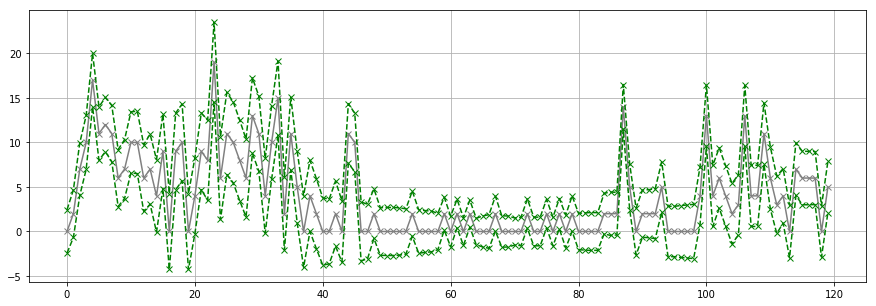

In [14]:
st, ed = 100, 220
ts_up, ts_low = ic(period_ts, *workload_aware(period_ts))
plt.figure(figsize=(15,5))
origin = period_ts[st:ed]
origin.index = range(len(origin))
plt.plot(origin, color='gray', marker='x')
plt.grid()
plt.plot(ts_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(ts_low[st:ed], linestyle='--', color='green', marker='x')